###Text, Image, **Video**
**For my video datasets, I first framing the videos into frame images and then use Fuyu to batch describe all the images to get texts and then compose a SOM of the texts.**

###Preparation

In [1]:
! pip install -q transformers bitsandbytes accelerate
! pip install --upgrade accelerate bitsandbytes
! pip install accelerate
! pip install -i https://test.pypi.org/simple/ bitsandbytes

Looking in indexes: https://test.pypi.org/simple/


In [2]:
import time
import cv2
import numpy as np
import torch
from google.colab.patches import cv2_imshow
from urllib.request import Request, urlopen
from transformers import AutoTokenizer, FuyuProcessor, FuyuImageProcessor, FuyuForCausalLM, BitsAndBytesConfig
import pdb

In [3]:
def url_to_image(url):
  """get image from web url"""
  #definition of User-Agent in header due to website blocking, also see here: https://stackoverflow.com/questions/16627227/problem-http-error-403-in-python-3-web-scraping
  req = Request(url=url, headers={'User-Agent': 'Mozilla/6.0'})
  resp = urlopen(req).read()
  image = np.asarray(bytearray(resp), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  return image

def show(image):
  """show an image in line"""
  cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def pprint(text, line_char=88):
  """pretty print text by limit line characters"""
  last_char = "" # handle last word in each line
  for i in range(0, len(text), line_char):
    line = text[i:i+line_char]
    line = last_char+line
    last_char = ""
    line = line.split(" ")
    last_char = line[-1]
    if i <= len(text)-line_char:
      # handle last word in last line
      line = line[:-1]
    print(" ".join(line))

def run_example(prompt, img_url):
  """run example with prompt and image url"""
  # get and show image
  image = url_to_image(img_url)
  show(image)
  # run the model
  output = fuyu.prompt(prompt, image, out_tokens=100)
  # pretty print example info
  pprint(f"\nGiven \x1b[1;31mimage\x1b[0m \x1B[3m{img_url}\x1B[0m \x1b[1;31mand\x1b[0m the following \x1b[1;31mprompt\x1b[0m:\n\n\x1B[3m{prompt}\x1B[0m", 80)
  pprint(f"The \x1b[1;31mmodels output\x1b[0m:\n\n\x1B[3m{output}\x1B[0m\n", 88)

In [4]:
# check runtime type
if torch.cuda.is_available():
  model_id="ybelkada/fuyu-8b-sharded"
  print(f"\nUsing the sharded model '{model_id}' with to GPU usage.\n")
  print("This model is faster due to 4bit quantization and GPU computation. 🚀\n")
else:
  model_id="adept/fuyu-8b"
  print(f"\nUsing the original model '{model_id}' without GPU usage.\n")
  print("This model, as of today, can't be 4bit quantized. Also the weights can't be fully loaded into memory in colab free tier.")
  print("Running it on CPU and without the above optimizations makes it extremely slow in computation, however you can still do it and run this 8 billion parameter model!\n")
  print("⚠️ For the sake of time, switch the runtime type to 'T4 GPU' or any other GPU type, otherwise it will take literally hours!\n")


Using the sharded model 'ybelkada/fuyu-8b-sharded' with to GPU usage.

This model is faster due to 4bit quantization and GPU computation. 🚀



In [5]:
class Fuyu():
    """Pretrained fuyu model of Adept via huggingface"""

    def __init__(self, model_id="ybelkada/fuyu-8b-sharded"):
        # check if GPU can be used
        if torch.cuda.is_available():
            print("You are running the model on GPU.")
            self.device = torch.device("cuda")
            self.dtype = torch.float16
            quantization_config = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_compute_dtype=self.dtype
            )
            self.model = FuyuForCausalLM.from_pretrained(model_id, quantization_config=quantization_config)
        else:
            print("You are running the model on CPU, the runtime might be very slow. 🐌")
            self.device = torch.device("cpu")
            self.dtype = torch.bfloat16
            # 4bit quantization is currently not working with the latest version of transformers (as of today: 4.35.0.dev0), it is working with transformers 4.30, however fuyu is not integrated there.
            self.model = FuyuForCausalLM.from_pretrained(model_id, device_map=self.device, torch_dtype=self.dtype)

        # initialize tokenizer and fuyu processor, pretrained and via huggingface
        self.tokenizer = AutoTokenizer.from_pretrained(model_id)
        self.processor = FuyuProcessor(image_processor=FuyuImageProcessor(), tokenizer=self.tokenizer)

    def prompt(self, text, image=None, out_tokens=50):
        """Prompt the model with a text and optional an image prompt."""

        if image is None:
            # if no image is provided, use a small black image
            # Warning: This is working but the model is not trained on this image fake. Test purpose only!
            image = np.zeros((30,30,3), dtype=np.uint8)

        # pre processing image and text
        inputs = self.processor(text=text, images=[image], return_tensors="pt").to(self.device)
        prompt_len = inputs["input_ids"].shape[-1]

        # process
        t0 = time.time()
        generation_output = self.model.generate(**inputs, max_new_tokens=out_tokens, pad_token_id=self.tokenizer.eos_token_id)
        print(f"\nGeneration time: {time.time()-t0:.0f}s")

        # post processing
        generation_text = self.tokenizer.decode(generation_output[0][prompt_len:], skip_special_tokens=True)
        return generation_text.lstrip()

###Model Instantiation

In [6]:
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

Looking in indexes: https://pypi.org/simple/


In [7]:
fuyu = Fuyu(model_id)

You are running the model on GPU.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/60.5k [00:00<?, ?B/s]

model-00001-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00002-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00003-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00004-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00011.safetensors:   0%|          | 0.00/1.91G [00:00<?, ?B/s]

model-00006-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00007-of-00011.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

model-00008-of-00011.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00009-of-00011.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

model-00010-of-00011.safetensors:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

model-00011-of-00011.safetensors:   0%|          | 0.00/22.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/11 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/848 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/6.13M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

### Testing

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


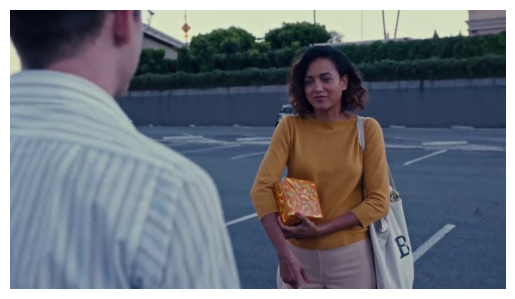

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
file_path ='/content/drive/My Drive/MoviesKeyframes/A SXSW Dark Comedy Short  The Voice In Your Head_frame_13422.jpg'
img = Image.open(file_path).convert('RGB')

plt.imshow(img)
plt.axis('off')
plt.show()

In [13]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Modify the url_to_image function to read from a local file
def file_to_image(file_path):
    """get image from local file path"""
    if os.path.exists(file_path):
        image = Image.open(file_path).convert('RGB')
        return image
    else:
        raise FileNotFoundError(f"File not found: {file_path}")

# Modify the run_example function to accept a local file path
def run_example(prompt, img_path):
    """run example with prompt and image file path"""
    # get and show image
    image = file_to_image(img_path)
    file_name = os.path.basename(img_path)
    print(file_name)

    # run the model
    output = fuyu.prompt(prompt, image, out_tokens=60)

    return output

In [14]:
image_path ='/content/drive/My Drive/MoviesKeyframes/A SXSW Dark Comedy Short  The Voice In Your Head_frame_13422.jpg'
text_prompt = 'Explain what objects are in this image in a sentence.'

generation_text = run_example(text_prompt,image_path)
generation_text

A SXSW Dark Comedy Short  The Voice In Your Head_frame_13422.jpg

Generation time: 7s


'In the image, there is a woman standing next to a man in a parking lot. The woman appears to be holding a bag, and the man is holding a small package. They are both standing next to each other.'

### Batch-parsing Movie Frames

In [15]:
import os
import shutil

def move_images_to_subfolders(source_folder, destination_folder, batch_size=200):
    os.makedirs(destination_folder, exist_ok=True)

    file_list = os.listdir(source_folder)
    file_list.sort()

    num_subfolders = len(file_list) // batch_size + (1 if len(file_list) % batch_size != 0 else 0)

    for i in range(num_subfolders):
        subfolder_path = os.path.join(destination_folder, f'subImagefolder_{i+1}')
        os.makedirs(subfolder_path, exist_ok=True)

        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(file_list))

        for j in range(start_index, end_index):
            file_name = file_list[j]
            source_file_path = os.path.join(source_folder, file_name)
            destination_file_path = os.path.join(subfolder_path, file_name)
            shutil.move(source_file_path, destination_file_path)

In [16]:
source_folder = '/content/drive/My Drive/MoviesKeyframes'
destination_folder = '/content/drive/My Drive/Datasets_frames/'

move_images_to_subfolders(source_folder, destination_folder, batch_size=200)

In [17]:
import os

def list_files_in_directory(directory):
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            files.append(os.path.join(root, filename))
    return files

In [18]:
output_list=[]
image_path_list=[]

In [19]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_1'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

A SXSW Dark Comedy Short  The Voice In Your Head_frame_13422.jpg

Generation time: 5s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_11396.jpg

Generation time: 5s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_13630.jpg

Generation time: 4s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_11113.jpg

Generation time: 7s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_10105.jpg

Generation time: 5s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_10557.jpg

Generation time: 5s
A SXSW Dark Comedy Short  The Voice In Your Head_frame_10031.jpg

Generation time: 3s
A Love Story  BAFTA-winning Short Animation Film by Anushka Naanayakkara_frame_9799.jpg

Generation time: 3s
A Love Story  BAFTA-winning Short Animation Film by Anushka Naanayakkara_frame_8712.jpg

Generation time: 6s
A Love Story  BAFTA-winning Short Animation Film by Anushka Naanayakkara_frame_7713.jpg

Generation time: 4s
A Love Story  BAFTA-winning Short Animation Film by Anushka Naanayakkar

In [20]:
len(output_list)

200

In [21]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_2'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_4519.jpg

Generation time: 4s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_3097.jpg

Generation time: 4s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_4312.jpg

Generation time: 5s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_2947.jpg

Generation time: 5s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_12576.jpg

Generation time: 6s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_1981.jpg

Generation time: 4s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_251.jpg

Generation time: 3s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_14354.jpg

Generation time: 4s
Clare  A studentteacher relationship goes too far in this LGTBQ+ short film_frame_15005.jpg

Generation

In [22]:
len(output_list)

400

In [23]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_3'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_8934.jpg

Generation time: 7s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_8867.jpg

Generation time: 7s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_7613.jpg

Generation time: 4s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_7732.jpg

Generation time: 3s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_738.jpg

Generation time: 4s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_7975.jpg

Generation time: 3s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_8859.jpg

Generation time: 5s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_6468.jpg

Generation time: 5s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_6276.jpg

Generation time: 4s
Garden Party  Oscar Nominated CG Animation  Short of the Week_frame_5920.jpg

Generation time: 3s
Garden Party  Oscar N

In [24]:
len(output_list)

600

In [25]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_4'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_1863.jpg

Generation time: 7s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_2543.jpg

Generation time: 3s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_2944.jpg

Generation time: 3s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_1020.jpg

Generation time: 3s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_2257.jpg

Generation time: 4s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_3959.jpg

Generation time: 3s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_4491.jpg

Generation time: 5s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_6484.jpg

Generation time: 3s
Lost & Found  Oscar Shortlisted Stop-Motion Animation  Short of the Week_frame_1172.jpg

Generation time: 4s
Lost & Found  Oscar

In [26]:
len(output_list)

800

In [27]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_5'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

Sci-Fi VFX Short Film  Uncanny Valley_frame_4121.jpg

Generation time: 7s
Sci-Fi VFX Short Film  Uncanny Valley_frame_301.jpg

Generation time: 3s
Sci-Fi VFX Short Film  Uncanny Valley_frame_3687.jpg

Generation time: 5s
Sci-Fi VFX Short Film  Uncanny Valley_frame_1809.jpg

Generation time: 5s
Sci-Fi VFX Short Film  Uncanny Valley_frame_3770.jpg

Generation time: 4s
Sci-Fi VFX Short Film  Uncanny Valley_frame_4925.jpg

Generation time: 3s
Sci-Fi VFX Short Film  Uncanny Valley_frame_11954.jpg

Generation time: 3s
Sci-Fi VFX Short Film  Uncanny Valley_frame_10493.jpg

Generation time: 3s
Richard Madden (Game of Thrones) stars in Award-Winning Rally Short Film  Group B_frame_9147.jpg

Generation time: 4s
Richard Madden (Game of Thrones) stars in Award-Winning Rally Short Film  Group B_frame_7076.jpg

Generation time: 4s
Richard Madden (Game of Thrones) stars in Award-Winning Rally Short Film  Group B_frame_35217.jpg

Generation time: 3s
Richard Madden (Game of Thrones) stars in Award-Winn

In [28]:
len(output_list)

1000

In [29]:
folder_path = '/content/drive/My Drive/Datasets_frames/subImagefolder_6'
prompt='Explain what objects are in this image in a sentence.'

file_list = list_files_in_directory(folder_path)
for file in file_list:
  img_path = file
  output = run_example(prompt, img_path)
  output_list.append(output)
  image_path_list.append(file)

sometimes i think about dying  Sundance Short Film About Depression_frame_9234.jpg

Generation time: 4s
sometimes i think about dying  Sundance Short Film About Depression_frame_9124.jpg

Generation time: 5s
sometimes i think about dying  Sundance Short Film About Depression_frame_7774.jpg

Generation time: 4s
sometimes i think about dying  Sundance Short Film About Depression_frame_8660.jpg

Generation time: 4s
sometimes i think about dying  Sundance Short Film About Depression_frame_7186.jpg

Generation time: 7s
sometimes i think about dying  Sundance Short Film About Depression_frame_5215.jpg

Generation time: 3s
sometimes i think about dying  Sundance Short Film About Depression_frame_703.jpg

Generation time: 3s
sometimes i think about dying  Sundance Short Film About Depression_frame_6157.jpg

Generation time: 5s
sometimes i think about dying  Sundance Short Film About Depression_frame_2493.jpg

Generation time: 3s
sometimes i think about dying  Sundance Short Film About Depressi

In [30]:
len(output_list)

1120

In [31]:
output_list[0]

'In the image, there is a woman standing next to a man in a parking lot. The woman appears to be holding a bag, and the man is holding a small package. They are both standing next to each other.'

In [32]:
len(image_path_list)

1120

In [33]:
filename_list=[]
for i in range (0,len(image_path_list)):
  filename=os.path.basename(image_path_list[i])
  filename_list.append(filename)

In [34]:
len(filename_list)

1120

### Export CSV


In [35]:
import csv

def write_to_csv(filename_list, output_list, csv_file_path):
    with open(csv_file_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Filename', 'Text'])

        for filename, output in zip(filename_list, output_list):
            writer.writerow([filename, output])


csv_file_path = '/content/drive/My Drive/Datasets_frames/Frame_Textualisation.csv'
write_to_csv(filename_list, output_list, csv_file_path)